# CS160P Final Project: Automated Essay Scoring

Submitted by Charmaine Eunice Rabano

### Project Information

#### Essay Set

Not all essay sets will be used to avoid confusions with the differences in essay type and scoring range. Only essay sets #5 and #6 will be used because these sets are almost similar and both have scoring range of 0-4. They also have the highest training set size.


#### Features
1. Sentence count
2. Word count
3. Character count
4. Lemma count
5. Noun count
6. Verb count
7. Sentiment neutral score


#### Models

Classification and regression using ensemble learning techniques
1. Random Forest Classifier and Regressor
2. AdaBoost Classifier and Regressor
3. Gradient Boosting Classifier and Regressor
4. XGBoost Classifier and Regressor


#### Hyperparameter Tuning
GridSearchCV


#### Evaluation
Cohen's kappa score

### Dataset Import and Filtering

In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

In [2]:
df = pd.read_csv('essay_dataset.csv')

In [3]:
df = df[(df['essay_set'] >= 5) & (df['essay_set'] <= 6)]
df = df[['essay', 'domain1_score']]

print(df)

                                                   essay  domain1_score
7081   In this memoir of Narciso Rodriguez, @PERSON3'...            2.0
7082   Throughout the excerpt from Home the Blueprint...            2.0
7083   The mood the author created in the memoir is l...            3.0
7084   The mood created by the author is showing how ...            1.0
7085   The mood created in the memoir is happiness an...            3.0
...                                                  ...            ...
10681  The one obstacle the builders had when trying ...            0.0
10682  Some of the problems with the constructing of ...            2.0
10683  The builders of the Empire State building face...            3.0
10684  The obstacles the builders of the Empire State...            2.0
10685  You want me to tell you what they had to go th...            2.0

[3605 rows x 2 columns]


<AxesSubplot:xlabel='domain1_score', ylabel='count'>

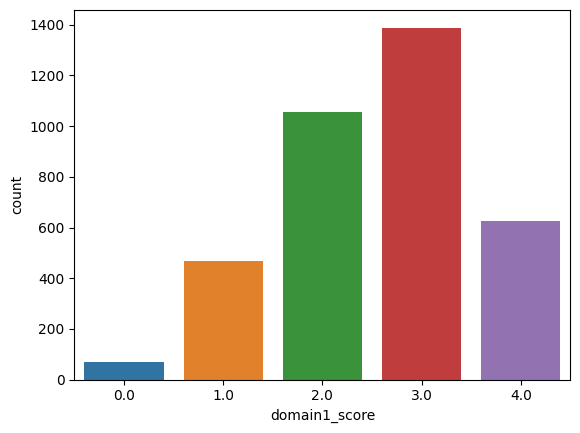

In [4]:
sns.countplot(x=df['domain1_score'])

### Feature Extraction

In [5]:
# number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [6]:
# number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [7]:
# number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [8]:
# tokenize

# sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens



# essay into words

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [9]:
# number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [10]:
# number of nouns and verbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    verb_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            
    return noun_count, verb_count

In [11]:
# sentiment neutral score

sia = SentimentIntensityAnalyzer()

def sentiment_analyzer(essay):
    
    scores = sia.polarity_scores(essay)
    
    return scores['neu']

In [12]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['noun_count'], features['verb_count'] = zip(*features['essay'].map(count_pos))
    
    features['sentiment'] = features['essay'].apply(sentiment_analyzer)
    
    return features

In [13]:
df_features = extract_features(df)

print(df_features)

                                                   essay  domain1_score  \
7081   In this memoir of Narciso Rodriguez, @PERSON3'...            2.0   
7082   Throughout the excerpt from Home the Blueprint...            2.0   
7083   The mood the author created in the memoir is l...            3.0   
7084   The mood created by the author is showing how ...            1.0   
7085   The mood created in the memoir is happiness an...            3.0   
...                                                  ...            ...   
10681  The one obstacle the builders had when trying ...            0.0   
10682  Some of the problems with the constructing of ...            2.0   
10683  The builders of the Empire State building face...            3.0   
10684  The obstacles the builders of the Empire State...            2.0   
10685  You want me to tell you what they had to go th...            2.0   

       sent_count  word_count  char_count  lemma_count  noun_count  \
7081            8         133

<AxesSubplot:xlabel='sentiment', ylabel='domain1_score'>

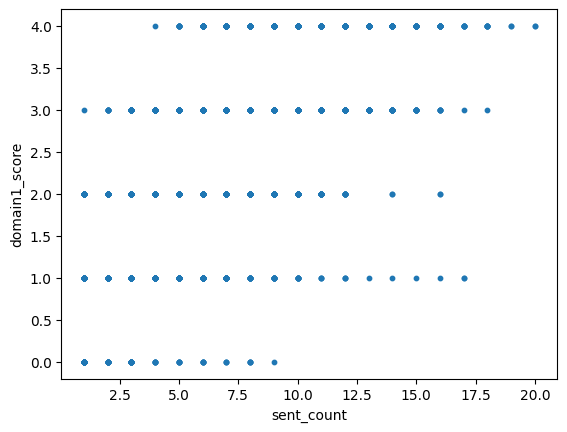

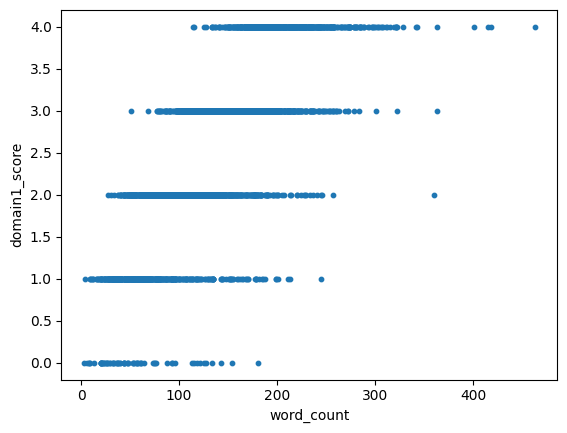

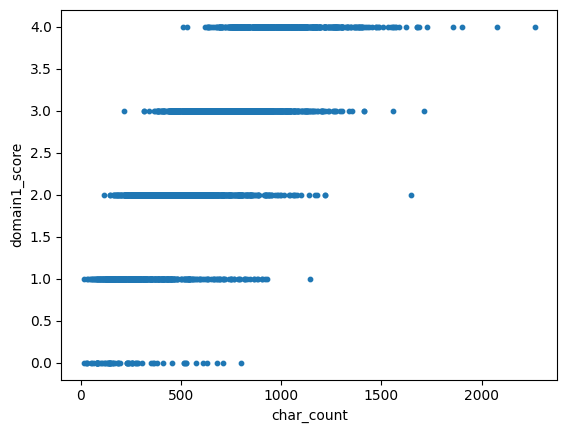

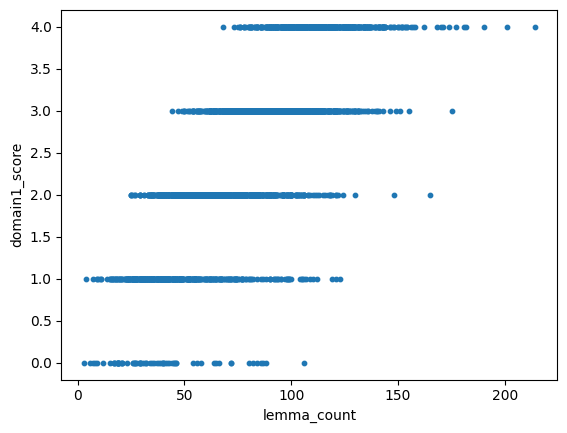

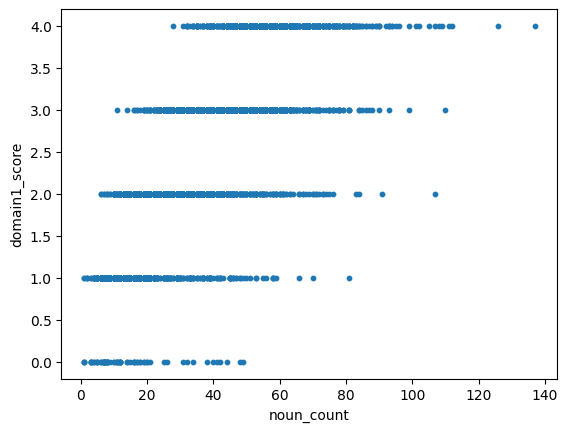

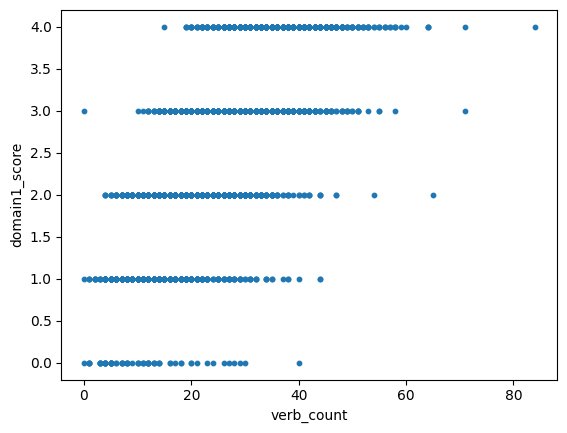

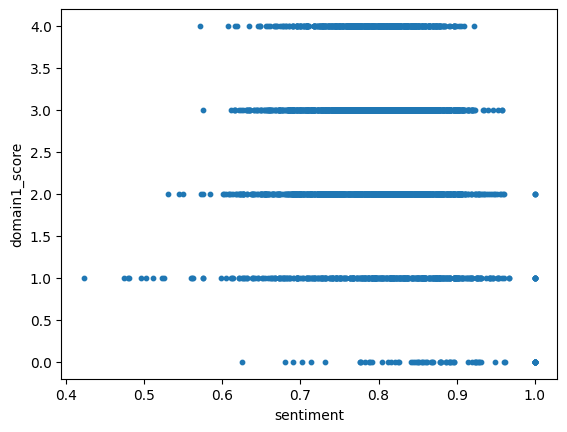

In [14]:
# Exploratory Data Analysis

df_features.plot.scatter(x='sent_count', y='domain1_score', s=10)
df_features.plot.scatter(x='word_count', y='domain1_score', s=10)
df_features.plot.scatter(x='char_count', y='domain1_score', s=10)
df_features.plot.scatter(x='lemma_count', y='domain1_score', s=10)
df_features.plot.scatter(x='noun_count', y='domain1_score', s=10)
df_features.plot.scatter(x='verb_count', y='domain1_score', s=10)
df_features.plot.scatter(x='sentiment', y='domain1_score', s=10)

### Modeling

In [15]:
feature_list = ['sent_count', 'word_count', 'char_count', 'lemma_count', 'noun_count', 'verb_count', 'sentiment']

X = df_features[feature_list]
y = df_features['domain1_score']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [17]:
from sklearn.model_selection import GridSearchCV

#### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [19]:
# Random Forest Default Classifier and Regressor

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
print('Random Forest Classifier Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, rfc_pred))

rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)
rfr_pred = rfr_model.predict(X_test)
print('Random Forest Regressor Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(rfr_pred)))

Random Forest Classifier Cohen's kappa score: 0.43
Random Forest Regressor Cohen's kappa score: 0.44


In [20]:
# Random Forest Classifier with GridSearchCV Hyperparameter Tuning

rfc_params = {'n_estimators':[100, 500, 1000], 
              'criterion':['gini','entropy','log_loss'], 
              'max_depth': [2, 10], 
              'max_features': ['sqrt', 'log2', None]}

rfc_grid = GridSearchCV(rfc_model, rfc_params, cv=3)
rfc_grid.fit(X_train, y_train)
rfc_grid_pred = rfc_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, rfc_grid_pred))
print(rfc_grid.best_estimator_)
print(rfc_grid.best_score_)

Cohen's kappa score: 0.47
RandomForestClassifier(max_depth=2, max_features='log2', n_estimators=1000)
0.6309948474038843


In [21]:
# Random Forest Regressor with GridSearchCV Hyperparameter Tuning

rfr_params = {'n_estimators':[100, 500, 1000],
              'criterion': ['squared_error', 'absolute_error', 'poisson'],
              'max_depth': [2, 10], 
              'max_features': ['sqrt', 'log2', None]}

rfr_grid = GridSearchCV(rfr_model, rfr_params, cv=3)
rfr_grid.fit(X_train, y_train)
rfr_grid_pred = rfr_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(rfr_grid_pred)))
print(rfr_grid.best_estimator_)
print(rfr_grid.best_score_)

Cohen's kappa score: 0.45
RandomForestRegressor(criterion='poisson', max_depth=10, max_features='sqrt',
                      n_estimators=500)
0.6266980943729517


#### AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

In [23]:
# AdaBoost Default Classifier and Regressor

abc_model = AdaBoostClassifier()
abc_model.fit(X_train, y_train)
abc_pred = abc_model.predict(X_test)
print('AdaBoost Classifier Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, abc_pred))

abr_model = AdaBoostRegressor()
abr_model.fit(X_train, y_train)
abr_pred = abr_model.predict(X_test)
print('AdaBoost Regressor Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(abr_pred)))

AdaBoost Classifier Cohen's kappa score: 0.16
AdaBoost Regressor Cohen's kappa score: 0.31


In [24]:
# AdaBoost Classifier with GridSearchCV Hyperparameter Tuning

abc_params = {'n_estimators':[100, 500, 1000],
             'learning_rate':[0.01, 0.1, 1.0]}

abc_grid = GridSearchCV(abc_model, abc_params, cv=3)
abc_grid.fit(X_train, y_train)
abc_grid_pred = abc_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, abc_grid_pred))
print(abc_grid.best_estimator_)
print(abc_grid.best_score_)

Cohen's kappa score: 0.29
AdaBoostClassifier(learning_rate=0.01, n_estimators=500)
0.562029330162505


In [25]:
# AdaBoost Regressor with GridSearchCV Hyperparameter Tuning

abr_params = {'n_estimators':[100, 500, 1000],
             'learning_rate':[0.01, 0.1, 1.0]}

abr_grid = GridSearchCV(abr_model, abr_params, cv=3)
abr_grid.fit(X_train, y_train)
abr_grid_pred = abr_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(abr_grid_pred)))
print(abr_grid.best_estimator_)
print(abr_grid.best_score_)

Cohen's kappa score: 0.47
AdaBoostRegressor(learning_rate=0.01, n_estimators=500)
0.609638305151098


#### Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [27]:
# Gradient Boosting Default Classifier and Regressor

gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)
gbc_pred = gbc_model.predict(X_test)
print('Gradient Boosting Classifier Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, gbc_pred))

gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)
print('Gradient Boosting Regressor Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(gbr_pred)))

Gradient Boosting Classifier Cohen's kappa score: 0.44
Gradient Boosting Regressor Cohen's kappa score: 0.46


In [28]:
# Gradient Boosting Classifier with GridSearchCV Hyperparameter Tuning

gbc_params = {'learning_rate': [0.01,0.02,0.03],
              'subsample': [0.9, 0.5, 0.2],
              'n_estimators': [100,500,1000],
              'max_depth': [4,6,8]}

gbc_grid = GridSearchCV(gbc_model, gbc_params, cv=3)
gbc_grid.fit(X_train, y_train)
gbc_grid_pred = gbc_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, gbc_grid_pred))
print(gbc_grid.best_estimator_)
print(gbc_grid.best_score_)

Cohen's kappa score: 0.43
GradientBoostingClassifier(learning_rate=0.01, max_depth=4, subsample=0.5)
0.6345620293301625


In [29]:
# Gradient Boosting Regressor with GridSearchCV Hyperparameter Tuning

gbr_params = {'learning_rate': [0.01,0.02,0.03],
              'subsample': [0.9, 0.5, 0.2],
              'n_estimators': [100,500,1000],
              'max_depth': [4,6,8]}

gbr_grid = GridSearchCV(gbr_model, gbr_params, cv=3)
gbr_grid.fit(X_train, y_train)
gbr_grid_pred = gbr_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(gbr_grid_pred)))
print(gbr_grid.best_estimator_)
print(gbr_grid.best_score_)

Cohen's kappa score: 0.45
GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          subsample=0.2)
0.6333596407380467


#### XGBoost

In [30]:
from xgboost import XGBClassifier, XGBRegressor

In [31]:
# XGBoost Default Classifier and Regressor

xgbc_model = XGBClassifier() # n_estimators=30,random_state=7
xgbc_model.fit(X_train, y_train)
xgbc_pred = xgbc_model.predict(X_test)
print('XGBoost Classifier Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, xgbc_pred))

xgbr_model = XGBRegressor()
xgbr_model.fit(X_train, y_train)
xgbr_pred = xgbr_model.predict(X_test)
print('XGBoost Regressor Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(xgbr_pred)))

XGBoost Classifier Cohen's kappa score: 0.41
XGBoost Regressor Cohen's kappa score: 0.42


In [32]:
# XGBoost Classifier with GridSearchCV Hyperparameter Tuning

xgbc_params = {'max_depth': [2, 10],
               'n_estimators': [100, 500, 1000],
               'learning_rate': [0.1, 0.01, 0.05]}

xgbc_grid = GridSearchCV(xgbc_model, xgbc_params, cv=3)
xgbc_grid.fit(X_train, y_train)
xgbc_grid_pred = xgbc_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, xgbc_grid_pred))
print(xgbc_grid.best_estimator_)
print(xgbc_grid.best_score_)

Cohen's kappa score: 0.46
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)
0.6377328577090765


In [33]:
# XGBoost Regressor with GridSearchCV Hyperparameter Tuning

xgbr_params = {'max_depth': [2, 10],
               'n_estimators': [100, 500, 1000],
               'learning_rate': [0.1, 0.01, 0.05]}

xgbr_grid = GridSearchCV(xgbr_model, xgbr_params, cv=3)
xgbr_grid.fit(X_train, y_train)
xgbr_grid_pred = xgbr_grid.predict(X_test)

print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(y_test, np.rint(xgbr_grid_pred)))
print(xgbr_grid.best_estimator_)
print(xgbr_grid.best_score_)

Cohen's kappa score: 0.45
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)
0.6288684725476393


### Results

|                   | Default Classifier | Default Regressor | Classifier with Tuning | Regressor with Tuning |
|-------------------|--------------------|-------------------|------------------------|-----------------------|
| Random Forest     | 0.43               | 0.44              | **0.47**               | 0.45                  |
| AdaBoost          | 0.16               | 0.31              | 0.29                   | **0.47**              |
| Gradient Boosting | 0.44               | **0.46**          | 0.43                   | 0.45                  |
| XGBoost           | 0.41               | 0.42              | **0.46**               | 0.45                  |

#### Observations
1. The models that performed best, with 0.47 Cohen's kappa score, are the Random Forest Classifier with hyperparameter tuning and AdaBoost Regressor with hyperparameter tuning. Closely next to it are the Gradient Boosting Regressor with default parameters and XGBoost Classifier with hyperparameter tuning.
2. The models that underwent hyperparameter tuning generally performed better than the defaults. However, an exception to this is the Gradient Boosting Classifier and Regressor, although, it was not a huge difference. This possibly happened because of the poor choice of parameters indicated.
3. The regression models generally performed better than their classifier alternatives. Exceptions to this are the Random Forest and XGBoost Classifier that underwent hyperparameter tuning, which are 2 of the best performing models.
4. All models have a Cohen's kappa score of less than 0.50, which means that they all have a not very strong agreement with the human expert graders. This is possibly because of the choice of features. The agreement could be improved with the use of better and more correlated features.